# Import Dependencies

In [22]:
import cv2
import numpy as np
import csv
import glob
import pandas as pd
import os
from openpyxl import load_workbook
from openpyxl.chart import ScatterChart, Reference, Series
import datetime
import matplotlib.pyplot as plt
import scipy.optimize
import scipy.stats
from scipy.stats import norm
import io

# Setup
## File Paths and Sunspot Info
Here is where you set the folder for where the sunspot images are located, the name of the sunspot being analyzed, its location in the folder, and its pixel coordinates in the first image. 

The folders for where the sunspot processed data will be stored as also determined here.

In [23]:
Image_Path = '../data/solar_images/*.jpg'

# The name of the sunspot being analyzed
Sunspot_Name = '3738'

# The first and last image with the sunspot visible 
first_image_number = 89
last_image_number = first_image_number + 150
number_of_rows = last_image_number - first_image_number

# Initial coordinates of the sunspot in the first image 
Sunspot_initial_x = 57
Sunspot_initial_y = 297


# Sun parameters
sun_center_x, sun_center_y = 256, 256
sun_radius = 234

csv_file = f'../data/sunspot_data/Sunspot_{Sunspot_Name}.csv'
excel_file = f'../data/sunspot_data/Sunspot_{Sunspot_Name}.xlsx'

## Horizon's Telemetry Data
Because the SOHO spacecraft is orbiting the Lagrange 1 point, its latitude relative to the Sun changes over time. Here is where you load the spacecraft telemetry. The latitude of the spacecraft relative to the Sun is defined as $B_0$. 

In [24]:
horizons_file = '../data/horizons_results.txt' 

with open(horizons_file, 'r') as f:
    all_lines = f.readlines()

start_line_index = -1
end_line_index = -1

for i, line in enumerate(all_lines):
    if '$$SOE' in line:
        start_line_index = i + 1 
    elif '$$EOE' in line:
        end_line_index = i 
        break

data_block = "".join(all_lines[start_line_index:end_line_index])
data_io = io.StringIO(data_block)

horizons_df = pd.read_csv(
    data_io,
    delim_whitespace=True,
    names=['Date', 'Time', 'ObsSub-LON', 'ObsSub-LAT']
)

# turn text month names into dates
month_map = {
    'Jan': '01', 'Feb': '02', 'Mar': '03', 'Apr': '04', 'May': '05', 'Jun': '06',
    'Jul': '07', 'Aug': '08', 'Sep': '09', 'Oct': '10', 'Nov': '11', 'Dec': '12'
}
horizons_df['Date'] = horizons_df['Date'].str.replace(r'([A-Z][a-z]{2})', lambda m: month_map[m.group(1)], regex=True)

# convert to datetime object
horizons_df['datetime'] = pd.to_datetime(horizons_df['Date'] + ' ' + horizons_df['Time'], format='%Y-%m-%d %H:%M')
horizons_df = horizons_df.set_index('datetime')

# final table to be used to look up values later
b_naught_lookup = horizons_df['ObsSub-LAT']

/var/folders/8m/x8f071113t3d7gdwzp03c1f40000gn/T/ipykernel_14398/3181549289.py:19: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  horizons_df = pd.read_csv(


## Loading First Image
Using the initial sunspot coordinates inputted earlier, they are converted into coordinates centered on the Sun's center. The first image is loaded to get its dimensions and make a circular mask.

In [25]:
image_files = sorted(glob.glob(Image_Path))

initial_x_center = Sunspot_initial_x - sun_center_x
initial_y_center = Sunspot_initial_y - sun_center_x
initial_d = np.sqrt(initial_x_center **2 + initial_y_center **2)
initial_d_err = np.sqrt(0.5**2 + 0.5**2)

first_image = cv2.imread(image_files[first_image_number], cv2.IMREAD_GRAYSCALE)
height, width = first_image.shape

mask_y, mask_x = np.ogrid[:height, :width]
mask_distance = np.sqrt((mask_x - sun_center_x)**2 + (mask_y - sun_center_y)**2)
black_mask = mask_distance < sun_radius
black_mask = (black_mask).astype(np.uint8)

# Locating Sunspots

The method for tracking sunspot motion consists of creating a detection box around the initial position of the sunspot. The darkest pixel inside the detection box is taken to be the pixel coordinates of the sunspot. The next image in the sequence is loaded and the detection box is centered on the new position. This process is repeated for all images in the sequence.

For each image the distance of the sunspot from the center of the sun, $d$, is stored as the main distance to be plotted. In addition the following data are stored for each image: time delta from first image, file name, sunspot x and y coordinates, the error in $d$, the Sun radius, and the $B_0$ value. 

First the size of the detection box is decided. The time of image image is taken by splitting the filename and converting the timestamp to a datetime object. Because the radius of the Sun is not constant the radius of each image is calculated, and finally the $B_0$ values are obtained from look up table. 

In [26]:
r = 5           #this is the search radius of the box
positions = []

current_position = (Sunspot_initial_x, Sunspot_initial_y)
previous_movement = (0, 0)


first_img_name = os.path.basename(image_files[first_image_number])
parts = first_img_name.split('_')
first_timestamp_str = parts[0] + '_' + parts[1]
t_0 = datetime.datetime.strptime(first_timestamp_str, "%Y%m%d_%H%M")


for i in range(first_image_number, last_image_number):
    
    image = cv2.imread(image_files[i], cv2.IMREAD_GRAYSCALE)
    current_filename = os.path.basename(image_files[i])
    
    parts = current_filename.split('_')
    current_timestamp_str = parts[0] + '_' + parts[1]
    current_time_obj = datetime.datetime.strptime(current_timestamp_str, "%Y%m%d_%H%M")
    

    time_delta = current_time_obj - t_0
    image_time = time_delta.total_seconds() / 3600.0


    ret, thresh = cv2.threshold(image, 20, 255, cv2.THRESH_BINARY)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea)
    (x, y), radius = cv2.minEnclosingCircle(largest_contour)
    sun_center_x = int(x)
    sun_center_y = int(y)
    R_sun_t = radius

    B_0_degrees = b_naught_lookup.asof(current_time_obj)
    B_0_pixels = R_sun_t * np.sin(np.deg2rad(B_0_degrees))

    search_center_x = current_position[0] + previous_movement[0]
    search_center_y = current_position[1] + previous_movement[1]
    x_min = max(0, search_center_x - r)
    x_max = min(width, search_center_x + r + 1)
    y_min = max(0, search_center_y - r)
    y_max = min(height, search_center_y + r + 1)

    sub_image = image[y_min:y_max, x_min:x_max]
    black_sub_mask = black_mask[y_min:y_max, x_min:x_max]
    
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(sub_image, mask=black_sub_mask)
    min_x, min_y = min_loc
    
    global_x = x_min + min_x
    global_y = y_min + min_y
    
    global_x_center = global_x - sun_center_x
    global_y_center = global_y - sun_center_y
    d_vector = np.sqrt(global_x_center **2 + global_y_center **2) #get d vector from python, no need for excel
    d_err = np.sqrt(0.5**2 + 0.5**2)


    positions.append((
        image_time,     # 0. Time (hours)
        os.path.basename(image_files[i]),       # 1. Filename
        global_x,       # 2. Spot X
        global_y,       # 3. Spot Y
        d_vector,       # 4. Measured Distance (pixels)
        d_err,          # 5. Error in Distance (pixels)
        R_sun_t,        # 6. Sun Radius (pixels)
        B_0_pixels      # 7. SOHO Latitude (pixels)
    ))
    
    movement = (global_x - current_position[0], global_y - current_position[1])
    current_position = (global_x, global_y)
    previous_movement = movement



radius_columns = ['time', 'filename', 'x', 'y', 'd_vector', 'd_err', 'R_sun', 'B_0']
radius_df = pd.DataFrame(positions, columns=radius_columns)
print("done")

done


## Save Location Data to File
The data is written to a csv file. It is also converted to an excel file. Storing the sunspot data in files like this allows for quicker reanalysis of past sunspots without having to recalculate the sunspot positions if its not needed.

In [27]:
with open(csv_file, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Hours', 'Filename', 'x', 'y', 'd', 'd_err', 'R_sun', 'B_0'])
    for hours, Filename, x, y, d, d_err, R_sun, B_0 in positions:
        writer.writerow([hours, Filename, x, y, d, d_err, R_sun, B_0])

df = pd.read_csv(csv_file)
df.to_excel(excel_file, index=False)
wb = load_workbook(excel_file)
ws = wb.active
ws.column_dimensions['B'].width = 25.5

wb.save(excel_file)
df = pd.read_excel(excel_file)

## Plotting Sunspot Motion
Here the distance of the sunspot from the center of the sun over time is plotted.

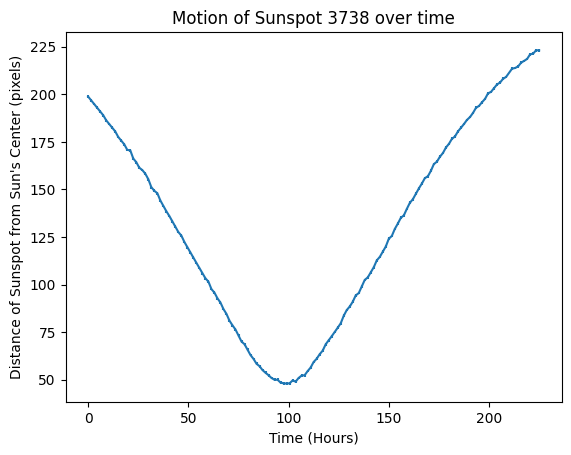

In [28]:
plt.figure()
plt.errorbar(df.iloc[0:number_of_rows, 0], df.iloc[0:number_of_rows, 4], yerr=df.iloc[0:number_of_rows,5])
plt.xlabel('Time (Hours)')
plt.ylabel('Distance of Sunspot from Sun\'s Center (pixels)')
plt.title('Motion of Sunspot '+ Sunspot_Name+ ' over time')
plt.show()

# Old Analysis Method to Calculate $\omega$
When the project was initially started this novel method of minimizing the sum of the function to determine the angular velocity $\omega$ was used. Later on this method was replaced by a $\chi^2$ minimization analysis. 

This function finds the initial value of $\omega$ by first calculating the value of 
$$f(\omega) = \int _0 ^T |d_m(\omega, t) - d(t)| \text{ d}t,$$
$\forall \,\omega \in \{ \omega_\text{min},\omega_\text{max}\}$. The value of $\omega$ which leads to the smallest value of this function is taken to be the best value of the angular velocity.

The latitude of the sunspot is calculated using the minimum value of the function. When the sunspot is at its minimum distance from the center of the sun its distance to the center of the sun is the same as its pixel distance to the equator. The hemisphere of the sunspot is then calculated by looking at the average y position of the sunspot.

Once the angular velocity of the sunspot is found, period of the rotation of the Sun at that latitude is calculated using 

$$
T = \frac{\pi}{12 \omega} \text{ days}.
$$

In [29]:
avg_y_position = df['y'].mean()
if avg_y_position > sun_center_y:
    hemisphere_sign = -1  
    print("Hemisphere: SOUTH")
else:
    hemisphere_sign = 1   
    print("Hemisphere: NORTH")


delta = hemisphere_sign * df.iloc[2:number_of_rows,4].min()
latitude = np.rad2deg(np.arcsin(delta/sun_radius))
latitude_radius = sun_radius * np.cos(latitude)
delta_idx = df.iloc[2:number_of_rows, 4].idxmin()
t_0 = df.iloc[delta_idx, 0]

print("d_min = ", delta)
print("The sunspot has a latitude of \u00B1", latitude, " degrees", sep="")
print("The radius of the circle of latitude is ", latitude_radius, " pixels", sep="")

min_omega = 0.010908308 
max_omega = 0.007272205
num_iterations = 1000 
iterations = (max_omega - min_omega)/num_iterations  
    
t = df.iloc[:number_of_rows, 0]
d = df.iloc[:number_of_rows, 4]
d_err = df.iloc[:number_of_rows, 5]
R_sun = df.iloc[:number_of_rows, 6]
B_0_values = df.iloc[:number_of_rows, 7]

def f(t, omega):
    return np.sqrt((sun_radius **2 - delta **2)*(np.sin(omega*(t-t_0)))**2 + delta **2)


omega_values = np.linspace(min_omega, max_omega, num_iterations)
data = {'t': t}
for omega in omega_values:
    data[omega] = f(t, omega)  
result_df = pd.DataFrame(data)

def dif(col_index):
    return np.abs(result_df.iloc[:, col_index + 1] - d)

data2 = {omega: dif(i) for i, omega in enumerate(omega_values)}
difference_df = pd.DataFrame(data2)

summed = difference_df.sum(axis=0)
sum_matrix = pd.DataFrame([summed])
best_omega = sum_matrix.iloc[0, :].idxmin()
print(f"Best omega = {best_omega}, Sum: {sum_matrix[best_omega].iloc[0]}")
Period = (np.pi)/(12*best_omega)
print(f"Period:  {Period}")

Hemisphere: SOUTH
d_min =  -48.01041553663121
The sunspot has a latitude of ±-11.83960986137583 degrees
The radius of the circle of latitude is 174.8753708346887 pixels
Best omega = 0.010096645368368368, Sum: 112.3422911243328
Period:  25.929343682738118


# New Method to Calculate $\omega$ - Using $\chi ^2$ Analysis

Now that we have a rough value for $\omega$ and the period, a full $\chi ^2$ anaylsis will give us a better value, as well as the error on that estimate.

The model equation which takes into account the changing radius of the Sun is,
$$d_m(\omega, t) = \sqrt{\left(R_\text{Sun}^2 - \delta^2\right) \sin ^2 (\omega [t- t_0]) + \delta^2}.$$


In order to take into account the motion of the SOHO spacecraft, the model equation changes to
$$d_{m}(\omega,t) = \sqrt{ (R_{\text{Sun}}(t)^2- \delta ^2) \sin^2(\omega [t-t_{0}])+ (\delta - B_{0}(t))^2 }.$$


Earlier versions of the model equation took into account the spherical shape of the Sun, but only in the x-axis. Applying spherical coordinate geometry to both axes leads to the final model equation:
$$X(t) = (R_{\text{Sun}}^2(t)- \delta ^2)\sin^2(\omega[t-t_{0}])$$
$$Y(t) = R_{\text{Sun}}(t)[\sin(\delta)\cos(B_{0}(t))-\cos(\delta)\sin(B_{0}(t))\cos(\omega(t-t_{0}))]$$
$$d_{m}(\omega,t) = \sqrt{X(t)^2 + Y(t)^2}= \sqrt{\left((R_\text{Sun}(t)^2- \delta ^2)\sin^2(\omega[t-t_{0}])\right)^2 +   \left(R_\text{Sun}(t)[\sin(\delta)\cos(B_{0}(t))-\cos(\delta)\sin(B_{0}(t)\cos(\omega(t-t_{0}))]\right)^2},$$
where the parameters that need to be varied are $\delta, \omega,$ and $t_0$.

## Changing Sun Radius and Spacecraft Latitude
These graphs help visualize how the Sun's radius and SOHO's latitude are changing over the time interval.

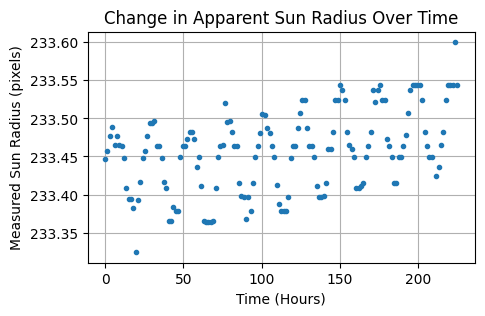

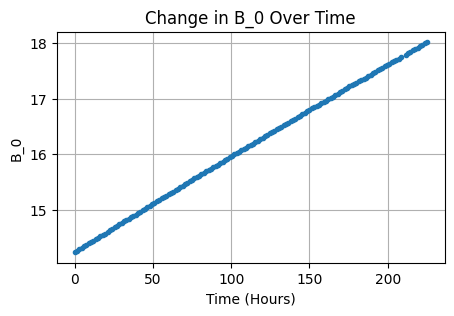

In [30]:
plt.figure(figsize=(5, 3))
plt.plot(radius_df['time'], radius_df['R_sun'], marker='.', linestyle='None')
plt.xlabel('Time (Hours)')
plt.ylabel('Measured Sun Radius (pixels)')
plt.title('Change in Apparent Sun Radius Over Time')
plt.grid(True) 
plt.show()


plt.figure(figsize=(5, 3))
plt.plot(radius_df['time'], radius_df['B_0'], marker='.', linestyle='None')
plt.xlabel('Time (Hours)')
plt.ylabel('B_0')
plt.title('Change in B_0 Over Time')
plt.grid(True) 
plt.show()

## Set up $\chi ^2$
This uses the values obtained from the old method as the initial estimate values.

Here is where the model function is defined and the varied parameters are defined. 

In [31]:
initial_values = np.array([delta, best_omega, t_0]) 
degrees_of_freedom = t.size - initial_values.size

def model_function(t, *params):
    model_x = np.sqrt(R_sun**2 - params[0]**2) * np.sin(params[1]*(t-params[2]))
    model_y = (params[0] * np.cos(np.arcsin(B_0_values/R_sun))) - (B_0_values * np.cos(np.arcsin(params[0]/R_sun)) * np.cos(params[1]*(t-params[2])))
    return np.sqrt(model_x**2 + model_y**2)

def chi_squared(model_params, model, x_data, y_data, y_err):
    return np.sum(((y_data - model(x_data, *model_params))/y_err)**2) 

## Actual $\chi ^2$ Analysis
Here is where the actual $\chi ^2$ minimization occurs. The output are the 3 optimized parameters as well as the covariance matrix which is used to calculate the errors in the optimized parameters.

In [32]:
lower_bounds = [-sun_radius, 0.0, -np.inf] 
upper_bounds = [sun_radius, np.inf, np.inf]

bounds = (lower_bounds, upper_bounds)
popt, cov = scipy.optimize.curve_fit(model_function, 
                                     t, 
                                     d, 
                                     sigma=d_err, 
                                     absolute_sigma=True,
                                     p0=initial_values, 
                                     check_finite=True,
                                     bounds = bounds)

print('Optimised parameters = ', popt, '\n')
print('Covariance matrix = \n', cov)

Optimised parameters =  [-3.35041788e+01  1.00626507e-02  9.89338248e+01] 

Covariance matrix = 
 [[1.90249274e-02 4.44016019e-07 1.11789386e-04]
 [4.44016019e-07 5.12492674e-11 2.09584485e-08]
 [1.11789386e-04 2.09584485e-08 1.49010440e-03]]


## Visualize
Here we visualize the sunspot motion, but now with the best fit curve plotted on top. The residuals and a histogram are also plotted below.

chi^2_min = 190.51138802242988
reduced chi^2 = 1.2959958368872782
P(chi^2_min, DoF) = 0.009107299034581056
DOF = 147
best fit $\delta$ = -33.50417876415041
best fit $\omega$ = 0.01006265065612726
best fit $t_0$ = 98.93382479168504
Period = 26.016940937896603
$\delta$ err = 0.13793087903774218
$\omega$ err = 7.158859362463956e-06
$\t_0$ err = 0.03860187041803508


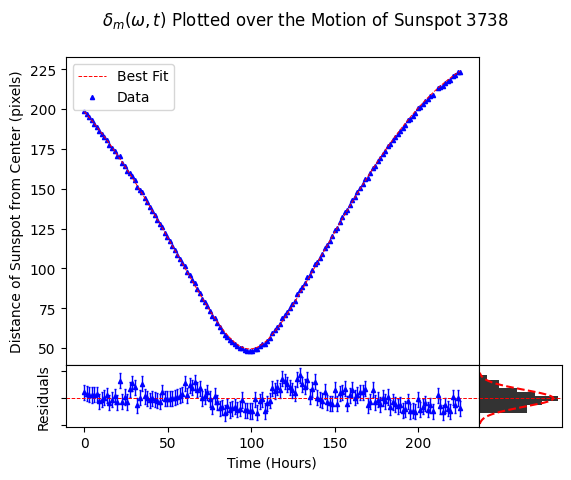

In [33]:
fig, axs = plt.subplots(2, 2,
                        gridspec_kw={'height_ratios': [5, 1], 'width_ratios': [5,1]}
                       , sharey='row'
                       )

fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)
axs[0,0].set_xticklabels([])  
axs[0, 1].axis('off')
axs[1, 1].tick_params(axis='both', which='both', length=0)  
axs[1, 1].set_xticklabels([])  
axs[1, 1].set_yticklabels([])


axs[0,0].errorbar(t,
             d, 
             #yerr = d_err, 
                  fmt = 'b^',
            #mfc='None',
                  capsize =1, markersize =3, elinewidth=1,    
             linestyle='None',
             zorder =1,
             label = 'Data')

B_0_plot_constant = np.mean(B_0_values)
R_sun_constant = np.mean(R_sun)
N_SMOOTH = number_of_rows * 50
t_smooth = np.linspace(np.min(t), np.max(t), N_SMOOTH)

axs[0,0].plot(np.linspace(np.min(t), np.max(t), number_of_rows*50), 
              np.sqrt((np.sqrt(R_sun_constant**2 - popt[0]**2) * np.sin(popt[1]*(t_smooth-popt[2])))**2+((popt[0] * np.cos(np.arcsin(B_0_plot_constant/R_sun_constant))) - (B_0_plot_constant * np.cos(np.arcsin(popt[0]/R_sun_constant)) * np.cos(popt[1]*(t_smooth-popt[2]))))**2),
              color = 'r', 
              linewidth = 0.7, 
              linestyle='--',
              zorder =2,
              label = 'Best Fit')

residual = d - model_function(t, *popt)
axs[1,0].errorbar(t, residual, capsize =1, fmt = 'b^',
            #mfc='None', 
                  markersize =3, elinewidth=1,yerr=d_err, linestyle = 'None')

axs[1,0].set_xlabel('Time (Hours)') 
axs[0,0].set_ylabel('Distance of Sunspot from Center (pixels)')

axs[1,0].set_ylabel('Residuals')
axs[1,0].axhline(y=0, color='r', linestyle='dashed', linewidth = 0.7)


##### Histogram #####
axs[1,1].hist(residual, bins =9, orientation='horizontal', color='k', alpha=0.8, density=True)

mu = np.mean(residual)
sigma = np.std(residual, ddof=1)
x_normdist = np.linspace(mu - 3*sigma, mu + 3*sigma, 1000)
y_normdist = norm.pdf(x_normdist, mu, sigma)
axs[1,1].plot(y_normdist, x_normdist, color='r', linestyle='dashed')

x_min, x_max = axs[0, 0].get_xlim()
axs[1, 0].set_xlim(x_min, x_max)
axs[1,1].axhline(y=0, color='r', linestyle='dashed', linewidth = 0.7)
###########


axs[0,0].legend()
fig.suptitle(r'$\delta _m(\omega, t)$ Plotted over the Motion of Sunspot ' + Sunspot_Name)
timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
os.path.join


chi_squared_min = chi_squared(popt, model_function, t, d, d_err)
reduced_chi_squared = chi_squared_min/degrees_of_freedom
p_value = scipy.stats.chi2.sf(chi_squared_min, degrees_of_freedom)
popt_errs = np.sqrt(np.diag(cov))
Period = (np.pi)/(12*popt[1])

print('chi^2_min = {}'.format(chi_squared_min))
print('reduced chi^2 = {}'.format(reduced_chi_squared))
print('P(chi^2_min, DoF) = {}'.format(p_value))
print('DOF = ' + str(degrees_of_freedom))
print(r"best fit $\delta$ = " + str(popt[0]))
print(r"best fit $\omega$ = " + str(popt[1]))
print(r"best fit $t_0$ = " + str(popt[2]))

print(r'Period = ' + str(Period))
#print(r'Viscocity_err = ' + str(Viscocity_err))
print(r"$\delta$ err = " + str(popt_errs[0]))
print(r"$\omega$ err = " + str(popt_errs[1]))
print(r"$\t_0$ err = " + str(popt_errs[2]))

plt.savefig(os.path.join("../graphs/sunspot_graphs", f"Sunspot_{Sunspot_Name}-Initial_{first_image_number}-Final_{last_image_number}-PValue_{p_value:.3g}.pdf"), format="pdf", bbox_inches="tight")

# Final Steps
## Compare Old Method and $\chi ^2$ Method
Here we can demonstrate how different the two methods were in their calculated values. The main differences come from the more accurate model equations.

In [34]:
R_sun_avg = df['R_sun'].mean()
new_latitude = np.rad2deg(np.arcsin(popt[0]/R_sun_avg))
latitude_dif = 100*(latitude- new_latitude)/(new_latitude)
omega_dif = 100*((best_omega-popt[1])/popt[1])
t_0_diff = 100*((t_0-popt[2])/(popt[2]))

compare = [
    ["Latitude", latitude, new_latitude , latitude- new_latitude, latitude_dif ],
    ["Omega", best_omega, popt[1], best_omega-popt[1], omega_dif],
    ["t_0", t_0, popt[2], t_0-popt[2], t_0_diff]
]
headers = ["Sunspot {}".format(Sunspot_Name), "Old Values", "Chi Squared Values", "Difference", "Percent Difference"]
compare_df = pd.DataFrame(compare, columns=headers)
print(compare_df)

new_latitude_err = np.abs(np.rad2deg(np.arcsin((popt[0]+popt_errs[0])/R_sun_avg)) - new_latitude)

  Sunspot 3738  Old Values  Chi Squared Values  Difference  Percent Difference
0     Latitude  -11.839610           -8.251197   -3.588413           43.489606
1        Omega    0.010097            0.010063    0.000034            0.337831
2          t_0   99.000000           98.933825    0.066175            0.066888


## Write Final Results to Excel File
Here the values are written to a final Excel file to be used in the next step.

In [35]:
Final_excel_file = '../data/New Final Data.xlsx'
first_image_name = os.path.basename(image_files[first_image_number-1])
last_image_name = os.path.basename(image_files[last_image_number])

new_data_row = [Sunspot_Name, new_latitude, new_latitude_err, popt[1], popt_errs[1], 
                chi_squared_min, reduced_chi_squared, p_value, first_image_number, last_image_number, 
                Sunspot_initial_x, Sunspot_initial_y, r, first_image_name, last_image_name]

file_exists = os.path.exists(Final_excel_file)

wb = load_workbook(Final_excel_file)
ws = wb.active

ws.append(new_data_row)

wb.save(Final_excel_file)
print('Sunspot {} successfully appended to excel file'.format(Sunspot_Name))

Sunspot 3738 successfully appended to excel file
